<a href="https://colab.research.google.com/github/Kalyla-Pinheiro/projeto_pso_equipe_on-a/blob/main/Projeto_pso_final_genial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Otimização por Enxame de Partículas (PSO) aplicada ao concreto

Este notebook implementa o projeto de Otimização por Enxame de Partículas (PSO) para maximizar a resistência à compressão do concreto aos 28 dias, utilizando um modelo de Random Forest treinado sobre a base concrete_data.csv.

##Objetivos
- Treinar um modelo de regressão Random Forest para predizer a resistência à compressão.
- Definir uma função objetivo *J(x)* baseada na previsão do modelo, penalizando composições cuja soma dos componentes ultrapasse a média M.
- Utilizar PSO para otimizar as proporções (kg/m³) dos 7 componentes da mistura, com idade fixada em 28 dias.
- Rodar múltiplas execuções do PSO, analisar convergência e sumarizar resultados.



## 1. Importação de bibliotecas e configuração inicial

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from typing import Callable, List, Tuple, Dict

from concrete_predictor import ConcreteStrengthPredictor

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True


## 2. Carregamento e exploração inicial dos dados

A base `concrete_data.csv` contém 1030 amostras de concreto, com:
- sete componentes em kg/m³ (cement, blastFurnaceSlag, flyAsh, water, superplasticizer, coarseAggregate, fineAggregate),
- a idade do concreto (em dias),
- a resistência à compressão (MPa).

Os dados serão utilizados para:
- obter os **limites mínimo e máximo** de cada componente;
- calcular o valor de referência **M** (média da soma dos componentes), utilizado na função objetivo J(x).

In [ ]:
# Caminho do arquivo de dados
CSV_PATH = 'concrete_data.csv'

df = pd.read_csv(CSV_PATH)
df.head()

,cement,blastFurnaceSlag,flyAsh,water,superplasticizer,coarseAggregate,fineAggregate,age,compressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [ ]:
# Informações gerais sobre o dataset
display(df.describe().T)
print('\nDimensões do dataset:', df.shape)
print('\nColunas:', df.columns.tolist())

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.165631,104.507142,102.000000,192.375000,272.900000,350.000000,540.000000
blastFurnaceSlag,1030.0,73.895485,86.279104,0.000000,0.000000,22.000000,142.950000,359.400000
flyAsh,1030.0,54.187136,63.996469,0.000000,0.000000,0.000000,118.270000,200.100000
water,1030.0,181.566359,21.355567,121.750000,164.900000,185.000000,192.000000,247.000000
superplasticizer,1030.0,6.203112,5.973492,0.000000,0.000000,6.350000,10.160000,32.200000
coarseAggregate,1030.0,972.918592,77.753818,801.000000,932.000000,968.000000,1029.400000,1145.000000
fineAggregate,1030.0,773.578883,80.175427,594.000000,730.950000,779.510000,824.000000,992.600000
age,1030.0,45.662136,63.169912,1.000000,7.000000,28.000000,56.000000,365.000000
compressiveStrength,1030.0,35.817836,16.705679,2.331808,23.707115,34.442774,46.136287,82.599225



Dimensões do dataset: (1030, 9)

Colunas: ['cement', 'blastFurnaceSlag', 'flyAsh', 'water', 'superplasticizer', 'coarseAggregate', 'fineAggregate', 'age', 'compressiveStrength']


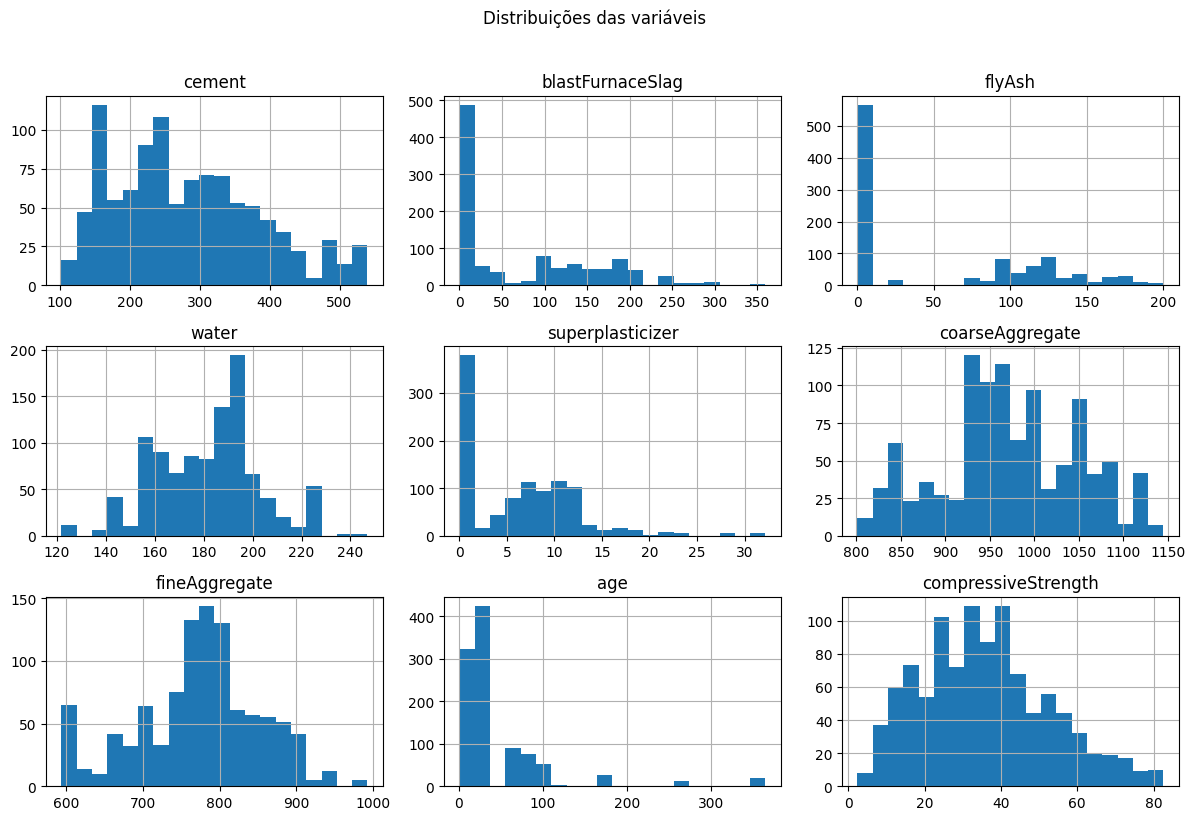

In [ ]:
# Histogramas simples das variáveis numéricas
df.hist(bins=20, figsize=(12, 8))
plt.suptitle('Distribuições das variáveis', y=1.02)
plt.tight_layout()
plt.show()

## 3. Modelo preditivo

O modelo Random Forest foi treinado previamente a partir de `concrete_data.csv` e salvo no arquivo `concrete_rf.pkl`. A classe `ConcreteStrengthPredictor`:

- carrega automaticamente o arquivo de modelo (`concrete_rf.pkl`);
- fixa a idade do concreto em `fixed_age = 28.0` dias;
- recebe as sete variáveis de entrada (em kg/m³) e retorna a resistência prevista (MPa).

A seguir, instanciamos o preditor e realizamos um teste simples de previsão.

In [ ]:
# Instancia o preditor usando o modelo pré-treinado
predictor = ConcreteStrengthPredictor(model_path='concrete_rf.pkl', fixed_age=28.0)

# Exemplo de previsão para uma composição qualquer
example_strength = predictor.predict(
    cement=400,
    blastFurnaceSlag=100,
    flyAsh=0,
    water=150,
    superplasticizer=10,
    coarseAggregate=1000,
    fineAggregate=800,
)
print(f'Resistência prevista (exemplo): {example_strength:.2f} MPa')

Resistência prevista (exemplo): 60.35 MPa


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## 4. Modelagem do problema de otimização

O objetivo é **maximizar a resistência à compressão aos 28 dias** variando as dosagens dos sete componentes do concreto (em kg/m³). As variáveis de decisão são:

- `cement`
- `blastFurnaceSlag`
- `flyAsh`
- `water`
- `superplasticizer`
- `coarseAggregate`
- `fineAggregate`

Primeiro, definimos a lista de componentes, calculamos os **limites mínimo e máximo** observados em `concrete_data.csv` e o valor de referência **M**, que é a **média da soma dos sete componentes** por amostra.

In [ ]:
COMPONENT_COLS = [
    'cement',
    'blastFurnaceSlag',
    'flyAsh',
    'water',
    'superplasticizer',
    'coarseAggregate',
    'fineAggregate',
]

# Limites (min, max) observados na base para cada componente
BOUNDS: List[Tuple[float, float]] = [
    (df[col].min(), df[col].max()) for col in COMPONENT_COLS
]

print('Limites por componente (min, max):')
for col, (lo, hi) in zip(COMPONENT_COLS, BOUNDS):
    print(f'  {col:16s}: [{lo:.2f}, {hi:.2f}]')

# M = média da soma dos 7 componentes
sum_components = df[COMPONENT_COLS].sum(axis=1)
M = float(sum_components.mean())
print(f"\nM (média da soma dos componentes) = {M:.4f} kg/m³")

Limites por componente (min, max):
  cement          : [102.00, 540.00]
  blastFurnaceSlag: [0.00, 359.40]
  flyAsh          : [0.00, 200.10]
  water           : [121.75, 247.00]
  superplasticizer: [0.00, 32.20]
  coarseAggregate : [801.00, 1145.00]
  fineAggregate   : [594.00, 992.60]

M (média da soma dos componentes) = 2343.5152 kg/m³


### 4.1 Função objetivo J(x)

A função objetivo definida na atividade é:

\begin{equation}
J(x) =
\begin{cases}
f(x_1, \ldots, x_7, 28), & \text{se } \sum_{i=1}^7 x_i \le M \\
f(x_1, \ldots, x_7, 28) - \lambda (\sum_{i=1}^7 x_i - M)^2, & \text{se } \sum_{i=1}^7 x_i > M
\end{cases}
\end{equation}

onde:
- $f(x_1, \ldots, x_7, 28)$ é a resistência prevista (MPa) pelo modelo Random Forest via `ConcreteStrengthPredictor`;
- $M$ é a **média da soma** dos sete componentes no dataset;
- $\lambda = 0{,}0002$ é o coeficiente de penalização.

O PSO será configurado para **maximizar** J(x).

In [ ]:
LAMBDA = 0.0002  # coeficiente de penalização

def objective(position: np.ndarray) -> float:
    """Função objetivo J(x) a ser maximizada pelo PSO.

    position: vetor com 7 componentes (kg/m³), na ordem de COMPONENT_COLS.
    """
    # Monta o dicionário de argumentos para o preditor
    values = dict(zip(COMPONENT_COLS, position))

    # f(x1,...,x7,28) – a idade já é incorporada pela classe (fixed_age = 28.0)
    f_val = float(predictor.predict(**values))

    total = float(np.sum(position))

    if total <= M:
        return f_val
    else:
        penalty = LAMBDA * (total - M) ** 2
        return f_val - penalty


## 5. Implementação do algoritmo de Otimização por Enxame de Partículas (PSO)

A seguir, implementamos o algoritmo **canônico de PSO** para variáveis contínuas, em modo de **maximização** da função objetivo J(x).

In [ ]:
def pso_optimize(
    objective: Callable[[np.ndarray], float],
    bounds: List[Tuple[float, float]],
    n_particles: int = 30,
    n_iterations: int = 80,
    w: float = 0.7,
    c1: float = 1.5,
    c2: float = 1.5,
    seed: int = None,
) -> Dict:
    """Algoritmo PSO em modo de MAXIMIZAÇÃO.

    Retorna um dicionário com:
      - best_position: melhor posição encontrada (vetor x*)
      - best_score: valor de J(x*) na melhor posição
      - history: melhor valor de J(x) a cada iteração
      - time: tempo total de execução (s)
    """
    rng = np.random.default_rng(seed)
    dim = len(bounds)

    # Inicialização de posições e velocidades
    positions = np.array([
        [rng.uniform(lo, hi) for (lo, hi) in bounds]
        for _ in range(n_particles)
    ])
    velocities = np.zeros_like(positions)

    # Melhor posição individual (pbest) e global (gbest)
    pbest_positions = positions.copy()
    pbest_scores = np.array([objective(pos) for pos in positions])

    best_idx = int(np.argmax(pbest_scores))
    gbest_position = pbest_positions[best_idx].copy()
    gbest_score = float(pbest_scores[best_idx])

    history = []
    start = time.time()

    for it in range(n_iterations):
        r1 = rng.random((n_particles, dim))
        r2 = rng.random((n_particles, dim))

        # Atualização da velocidade
        velocities = (
            w * velocities
            + c1 * r1 * (pbest_positions - positions)
            + c2 * r2 * (gbest_position - positions)
        )

        # Atualização das posições
        positions = positions + velocities

        # Restrição aos limites (clamping)
        for d, (lo, hi) in enumerate(bounds):
            positions[:, d] = np.clip(positions[:, d], lo, hi)

        # Avaliação das partículas
        scores = np.array([objective(pos) for pos in positions])

        # Atualização dos pbest
        better = scores > pbest_scores
        pbest_positions[better] = positions[better]
        pbest_scores[better] = scores[better]

        # Atualização do gbest
        best_idx = int(np.argmax(pbest_scores))
        if pbest_scores[best_idx] > gbest_score:
            gbest_score = float(pbest_scores[best_idx])
            gbest_position = pbest_positions[best_idx].copy()

        history.append(gbest_score)

    total_time = time.time() - start

    return {
        'best_position': gbest_position,
        'best_score': gbest_score,
        'history': history,
        'time': total_time,
    }


## 6. Experimentos com múltiplas execuções do PSO

Para avaliar a robustez do método, executamos o PSO **5 vezes** com sementes aleatórias diferentes. Para o conjunto de execuções, calculamos:

- melhor, pior, média e desvio padrão dos valores de J(x);
- tempo médio de execução e seu desvio padrão;
- a melhor solução encontrada (composição ótima) dentre todas as execuções.

In [ ]:
def run_experiments(
    n_runs: int = 5,
    n_particles: int = 30,
    n_iterations: int = 80,
    w: float = 0.7,
    c1: float = 1.5,
    c2: float = 1.5,
    base_seed: int = 2025,
) -> Dict:
    results = []
    scores = []
    times = []
    histories = []

    for run in range(n_runs):
        seed = base_seed + run
        res = pso_optimize(
            objective=objective,
            bounds=BOUNDS,
            n_particles=n_particles,
            n_iterations=n_iterations,
            w=w,
            c1=c1,
            c2=c2,
            seed=seed,
        )
        results.append(res)
        scores.append(res['best_score'])
        times.append(res['time'])
        histories.append(res['history'])

        print(
            f"[RUN {run+1}/{n_runs}] Melhor J(x): {res['best_score']:.4f} | "
            f"Tempo: {res['time']:.2f}s"
        )

    scores = np.array(scores, dtype=float)
    times = np.array(times, dtype=float)

    best_idx = int(np.argmax(scores))
    best_run = results[best_idx]

    stats = {
        'score_best': float(scores.max()),
        'score_worst': float(scores.min()),
        'score_mean': float(scores.mean()),
        'score_std': float(scores.std(ddof=1) if len(scores) > 1 else 0.0),
        'time_mean': float(times.mean()),
        'time_std': float(times.std(ddof=1) if len(scores) > 1 else 0.0),
    }

    print('\nResumo estatístico:')
    print(f"  Melhor J(x):       {stats['score_best']:.4f}")
    print(f"  Pior J(x):         {stats['score_worst']:.4f}")
    print(f"  Média J(x):        {stats['score_mean']:.4f} ± {stats['score_std']:.4f}")
    print(f"  Tempo médio (s):   {stats['time_mean']:.2f} ± {stats['time_std']:.2f}")

    return {
        'best_run': best_run,
        'all_scores': scores,
        'all_times': times,
        'all_histories': histories,
        'stats': stats,
    }


In [ ]:
# Executa os experimentos (5 execuções do PSO)
resultados = run_experiments(
    n_runs=5,
    n_particles=30,
    n_iterations=80,
    w=0.7,
    c1=1.5,
    c2=1.5,
    base_seed=2025,
)

best = resultados['best_run']
best_pos = best['best_position']

print('\n=== Melhor composição encontrada (PSO) ===')
for name, val in zip(COMPONENT_COLS, best_pos):
    print(f"  {name:16s}: {val:8.2f} kg/m³")

total_best = float(np.sum(best_pos))
print(f"\nSoma total dos componentes (melhor solução) = {total_best:.2f} kg/m³")

best_strength = float(predictor.predict(**dict(zip(COMPONENT_COLS, best_pos))))
print(f"Resistência prevista (modelo) na melhor solução: {best_strength:.4f} MPa")
print(f"Valor de J(x) na melhor solução: {best['best_score']:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

[RUN 1/5] Melhor J(x): 67.1671 | Tempo: 26.83s


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

[RUN 2/5] Melhor J(x): 67.6853 | Tempo: 27.53s


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

[RUN 3/5] Melhor J(x): 68.1046 | Tempo: 27.34s


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

[RUN 4/5] Melhor J(x): 64.6733 | Tempo: 28.68s


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

[RUN 5/5] Melhor J(x): 68.6006 | Tempo: 28.02s

Resumo estatístico:
  Melhor J(x):       68.6006
  Pior J(x):         64.6733
  Média J(x):        67.2462 ± 1.5322
  Tempo médio (s):   27.68 ± 0.70

=== Melhor composição encontrada (PSO) ===
  cement          :   395.71 kg/m³
  blastFurnaceSlag:   185.26 kg/m³
  flyAsh          :     0.00 kg/m³
  water           :   145.41 kg/m³
  superplasticizer:    11.11 kg/m³
  coarseAggregate :   832.64 kg/m³
  fineAggregate   :   755.54 kg/m³

Soma total dos componentes (melhor solução) = 2325.67 kg/m³
Resistência prevista (modelo) na melhor solução: 68.6006 MPa
Valor de J(x) na melhor solução: 68.6006


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## 7. Gráficos de convergência do PSO

Nesta seção, visualizamos:

- a curva de convergência da **melhor execução** (maior J(x));
- as curvas de convergência de **todas as execuções**, permitindo comparar o comportamento do algoritmo.

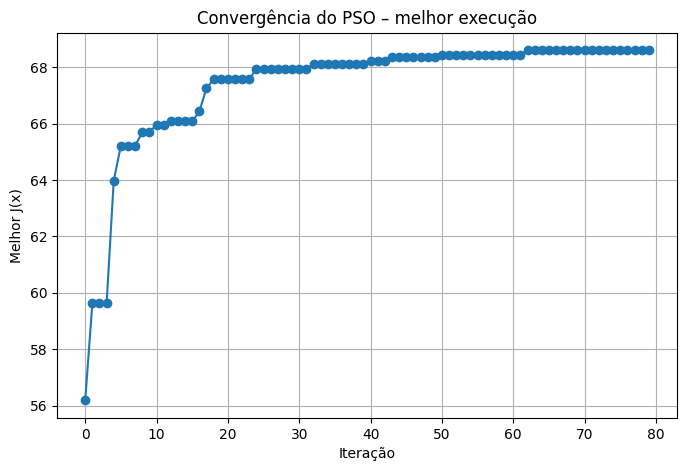

In [ ]:
# Curva de convergência da melhor execução
best_history = resultados['best_run']['history']

plt.figure()
plt.plot(best_history, marker='o')
plt.xlabel('Iteração')
plt.ylabel('Melhor J(x)')
plt.title('Convergência do PSO – melhor execução')
plt.grid(True)
plt.show()

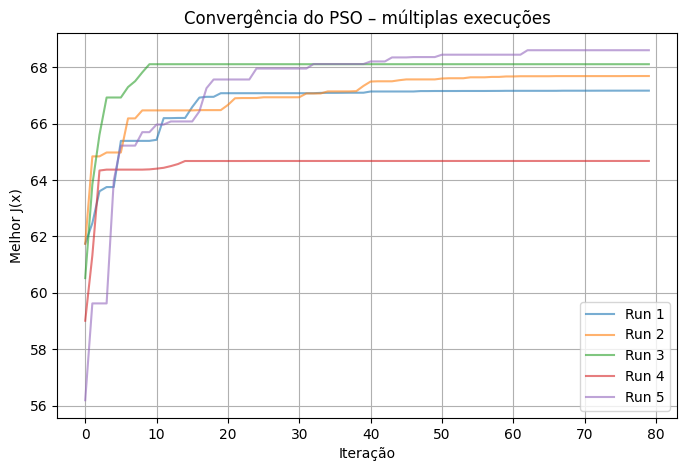

In [ ]:
# Curvas de convergência de todas as execuções
all_histories = resultados['all_histories']

plt.figure()
for i, hist in enumerate(all_histories):
    plt.plot(hist, alpha=0.6, label=f'Run {i+1}')
plt.xlabel('Iteração')
plt.ylabel('Melhor J(x)')
plt.title('Convergência do PSO – múltiplas execuções')
plt.legend()
plt.grid(True)
plt.show()